<a href="https://colab.research.google.com/github/performant23/decision-trees-credit-risk/blob/main/Model_Credit_Risk_using_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Reference - https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

This notebook aims to develop a Decision Tree model to classify a credit application as good/bad based on a customer's details like housing status, saving account status, age, etc. We'll start with simply training the DecisionTreeClassifier, then we aim to optimize the model by tuning the hyperparameters and then discuss the prospect of reducing dimensions and using boosting algorithms to check if we can improve performance and efficiency of the model

In [ ]:
#Importing the Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the Data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/german_credit_data.csv")
data = data.drop(['Unnamed: 0'], axis = 1)
data = data.dropna()

data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
7,35,male,3,rent,little,moderate,6948,36,car,good
9,28,male,3,own,little,moderate,5234,30,car,bad
...,...,...,...,...,...,...,...,...,...,...
989,48,male,1,own,little,moderate,1743,24,radio/TV,good
993,30,male,3,own,little,little,3959,36,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
# Obtaining Predictor Variable
Y = data['Risk'].astype(str).map({'good': 1, 'bad': 0})
Y

1      0
3      1
4      0
7      1
9      0
      ..
989    1
993    1
996    1
998    0
999    1
Name: Risk, Length: 522, dtype: int64

Since many features in the feature space are actually categorical variables like housing having values - free, own, and rent; we first need to encode these using one-hot encoding since there is no explicit hierarchy among the categorical values. We do that using the get_dummies function in pandas which will create an encoded copy of data with the one-hot encoding of the features passed into the function

In [ ]:
data_2 = data
one_hot_encoded_data = pd.get_dummies(data_2, columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'])
one_hot_encoded_data

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
1,22,2,5951,48,bad,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,45,2,7882,42,good,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,bad,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
7,35,3,6948,36,good,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,0
9,28,3,5234,30,bad,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,48,1,1743,24,good,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
993,30,3,3959,36,good,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
996,40,3,3857,30,good,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
998,23,2,1845,45,bad,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Obtaining Feature Space
X = one_hot_encoded_data.drop(['Risk'], axis = 1)
X

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
1,22,2,5951,48,1,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
3,45,2,7882,42,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,35,3,6948,36,0,1,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0
9,28,3,5234,30,0,1,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,48,1,1743,24,0,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
993,30,3,3959,36,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
996,40,3,3857,30,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
998,23,2,1845,45,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Data Cleaning - Checking for missing, negative, or invalid values
missing_values = X.isnull().sum()
zero_values = (X == 0).sum()
negative_values = (X < 0).sum()
invalid_values = pd.concat([missing_values, zero_values, negative_values], axis=1)
invalid_values.columns = ['Missing Values', 'Zero Values', 'Negative Values']
print(invalid_values)

                             Missing Values  Zero Values  Negative Values
Age                                       0            0                0
Job                                       0           14                0
Credit amount                             0            0                0
Duration                                  0            0                0
Sex_female                                0          354                0
Sex_male                                  0          168                0
Housing_free                              0          457                0
Housing_own                               0          173                0
Housing_rent                              0          414                0
Saving accounts_little                    0          110                0
Saving accounts_moderate                  0          458                0
Saving accounts_quite rich                0          499                0
Saving accounts_rich                  

Since we don't have any invalid data, we can proceed to building the model

In [ ]:
# Splitting the dataset into 'train' for training the model and 'test' - to test the model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Preprocessing the data to have mean - 0 and variance - 1
# This is done so that all data is treated 'equally' by the model

SSc = StandardScaler()
SSc.fit(X_train)

X_train = SSc.transform(X_train)
X_test = SSc.transform(X_test)


In [ ]:
# Creating an instance of DecisionTreeClassifier
clf = DecisionTreeClassifier()

clf.fit(X_train, Y_train)

# Predicting based on the model trained
Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
accuracy

0.5859872611464968

In [ ]:
#Additional metrics to evaluate the model
y_true = Y_test
y_pred = Y_pred

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(precision)
print(recall)
print(f1)

0.6265060240963856
0.6046511627906976
0.6153846153846154


It's worth noting that these accuracy scores are dependent on the split done by the function. Still, in general, we aren't getting really good accuracy with just training the classifier. So, we tune the hyperparameters to check if we can improve the model's efficiency. We do this using GridSearch

In [ ]:


param_grid = {
      'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_clf = grid_search.best_estimator_
print(best_score)
print(best_params)
print(best_clf)


0.6712328767123288
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10)


As we can see, tuning the hyperparameters considerably improves the performance of the model making it decent in general. Now, we can visualize the 'decision stumps' done by the model using 'plot_tree'.
(Note that the optimal parameters can be dependent on particular splits)

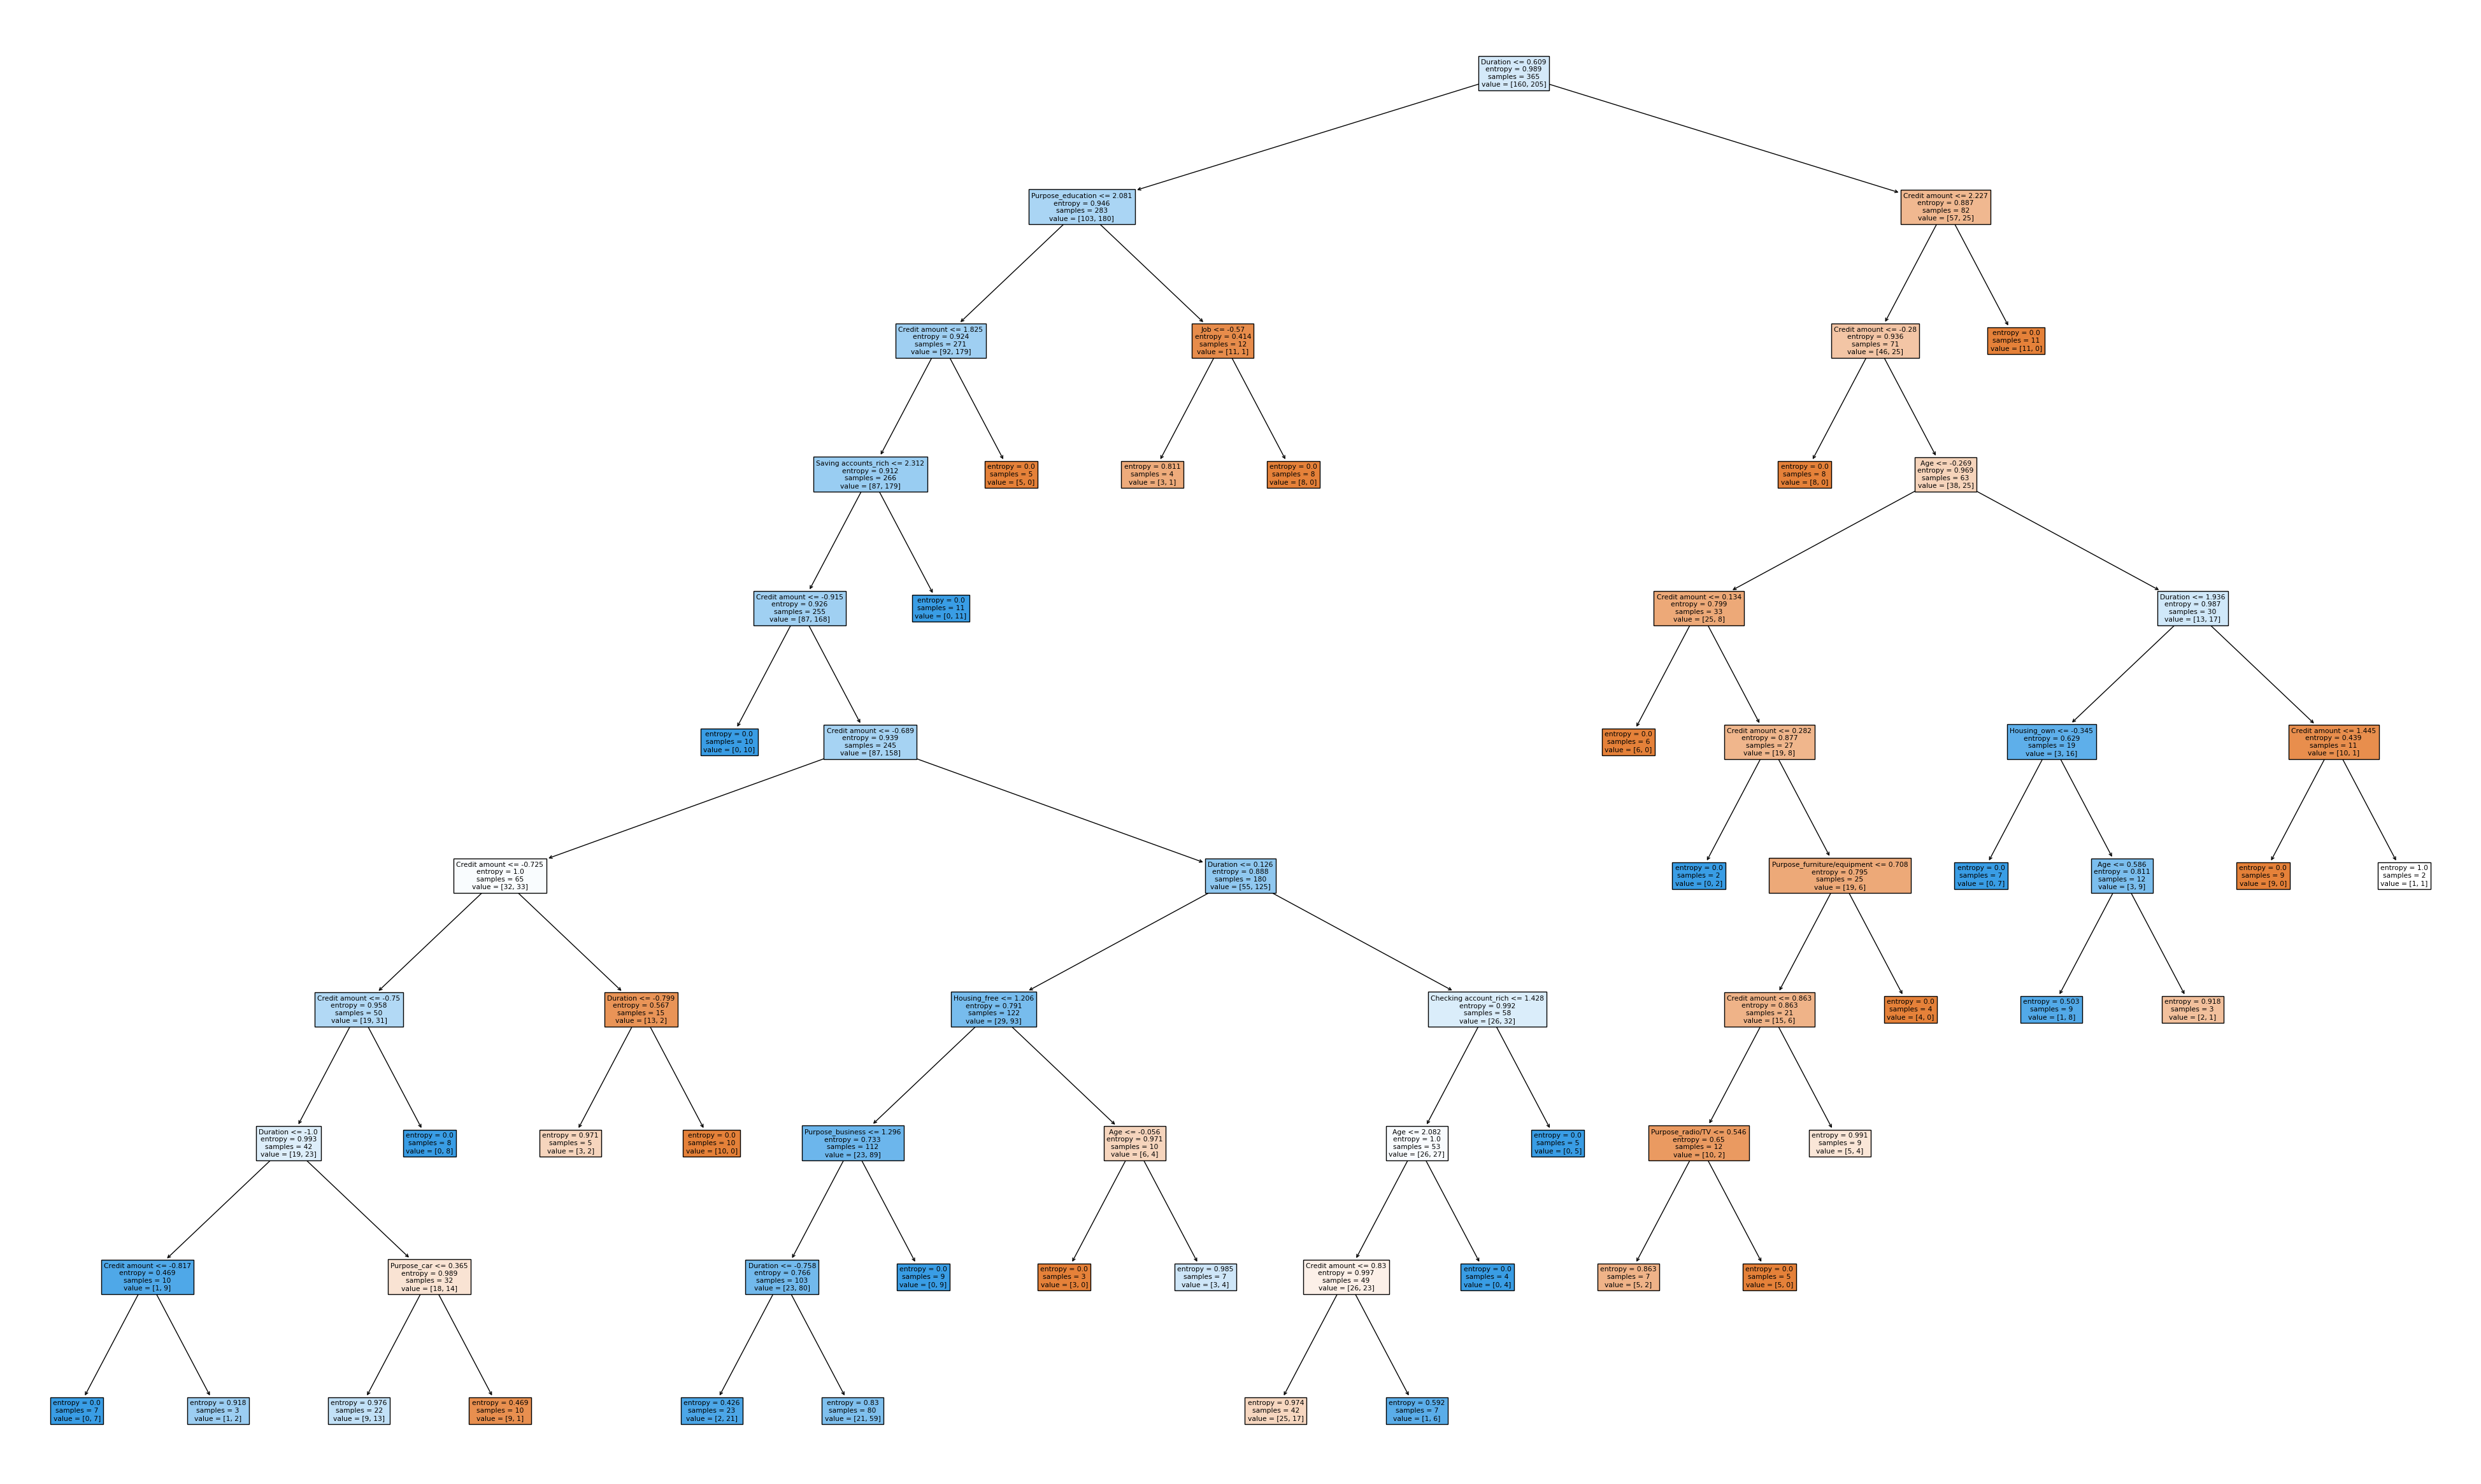

In [ ]:

clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2, min_samples_split=10)
clf.fit(X_train, Y_train)

from sklearn import tree
plt.figure(figsize=(50, 30))
tree.plot_tree(clf, filled=True, feature_names=X.columns)
plt.show()

A problematic thing about data with many categorical values is that, they are vulnerable to overfitting because every value in these categorical variables add another column to the data making it more complex (increasing variance). And most of these one-hot encoded values for a particular instance (row) of data are 0. So, we can try reducing the dimensionality using Principal Component Analysis (PCA) by only considering the features contributing most to the decision and see if we can improve the accuracy of the model.
(Using PCA in decision trees might seem irrelevant as compared to regression models because the categorical data can have an significant impact on the decision. We are just using it just to get an idea of the distribution of the data and features)

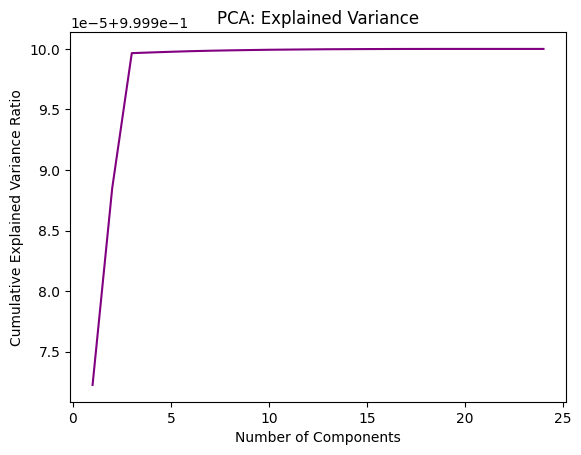

In [ ]:
# We can obtain the graph of Explained Variance to see the optimal number of components
pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color = 'purple')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Explained Variance')
plt.show()


In [ ]:
# We can see that '5' is about the optimal number. Still, we can verify with looping through different number of components
# and check the model's accuracy

for z in range(1,9):
    pca = PCA(n_components=z)
    X_pca = pca.fit_transform(X)
    X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4, min_samples_split=5)
    clf.fit(X_train_pca, Y_train)
    Y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(Y_test, Y_pred)
    print("Components: ", z)
    print("Accuracy:", accuracy)
    print()


Components:  1
Accuracy: 0.5668789808917197

Components:  2
Accuracy: 0.5031847133757962

Components:  3
Accuracy: 0.5414012738853503

Components:  4
Accuracy: 0.5477707006369427

Components:  5
Accuracy: 0.5732484076433121

Components:  6
Accuracy: 0.5796178343949044

Components:  7
Accuracy: 0.5414012738853503

Components:  8
Accuracy: 0.5477707006369427



We can see that for this particular split, 6 seems to be the optimal number of components to explain the data. Still, the accuracy is nowhere near decent. So, we can try using GridSearch to tune the parameters for reduced components

In [ ]:
pca = PCA(n_components=6)

X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.3, random_state=42)

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_pca, Y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_clf = grid_search.best_estimator_
print(best_score)
print(best_params)
print(best_clf)

0.6493150684931507
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=5)


We can see that using GridSearch to tune the parameters can potentially improve the model's accuracy. It is still less than the accuracy without reducing the dimensions, but the model can potentially generalize well. In conclusion, the present data might be insufficient to represent every type of customer and decide if reducing dimensions will improve the performance of the model (we risk having high bias with simpler model). So, obtaining more data to represent the diverse distribution of customers can potentially help choose between using model with all features or using dimensionality reduction algorithm like PCA.

To further improve the performance of the model, we can use boosting methods. Since we have a relatively small dataset, we can use Adaboost which basically combines weak learners to overall improve the model. Whether Adaboost results in a more efficient model will depend on different factors like: Is Adaboost overfitting the data?, For this data, are there sufficient weak learners to create a strong one?, etc. Also, for Adaboost, the fact that our data is relatively small can also make the difference.

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

SSc = StandardScaler()
SSc.fit(X_train)

X_train = SSc.transform(X_train)
X_test = SSc.transform(X_test)
param_grid = {
    'estimator__max_depth': [4, 10, 20],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

estimator = DecisionTreeClassifier()
adaboost = AdaBoostClassifier(estimator=estimator)
grid_search = GridSearchCV(adaboost, param_grid, cv=5)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_model.fit(X_train, Y_train)
print(best_model)
Y_pred = best_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.5, n_estimators=150)
Accuracy: 0.6114649681528662
